## Q1 Sparse Encoding for Denoising

In [9]:
import random, numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
seed = 1337
torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)

# Hyperparameters
IMG_H, IMG_W = 28, 28
INPUT_DIM = IMG_H * IMG_W
H_DIM = int(1.5 * INPUT_DIM)
LAMBDA_L1 = 1e-3               # L1 on codes
LR = 1e-3
BATCH_SIZE = 128
EPOCHS = 10
TRAIN_SIGMA = 0.3

# Data
tfm = transforms.ToTensor()  # maps to [0,1]
train_ds = datasets.MNIST(root="./data", train=True, transform=tfm, download=True)
test_ds  = datasets.MNIST(root="./data", train=False, transform=tfm, download=True)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

def add_noise(x, sigma):
    if sigma == 0:
        return x
    z = x + sigma * torch.randn_like(x)
    return torch.clamp(z, 0.0, 1.0)


In [10]:
class Encoder(nn.Module):
    def __init__(self, in_dim=INPUT_DIM, h_dim=H_DIM):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, h_dim),
        )
    def forward(self, x_flat):
        return self.net(x_flat)

class LinearDecoder(nn.Module):
    """
    Explicit dictionary D: x_hat = h @ D
    D has shape [h_dim, in_dim]. (Each row is a 'dictionary atom' reshaped to 28x28.)
    """
    def __init__(self, h_dim=H_DIM, in_dim=INPUT_DIM):
        super().__init__()
        # Initialize near-orthogonal for stability
        self.D = nn.Parameter(torch.empty(h_dim, in_dim))
        nn.init.xavier_uniform_(self.D)

    def forward(self, h):
        # h: [B, h_dim]  ->  x_hat_flat: [B, in_dim]
        return h @ self.D

class SparseDenoisingAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = Encoder(INPUT_DIM, H_DIM)
        self.dec = LinearDecoder(H_DIM, INPUT_DIM)
    def forward(self, x):
        # x: [B,1,28,28] -> flatten
        x_flat = x.view(x.size(0), -1)
        h = self.enc(x_flat)                 # nonlinear encoding
        x_hat_flat = self.dec(h)             # explicit linear decoding
        x_hat = x_hat_flat.view(-1, 1, 28, 28)
        return x_hat, h

model = SparseDenoisingAE().to(device)
opt = torch.optim.Adam(model.parameters(), lr=LR)


In [11]:
def mse_loss(a, b):
    return F.mse_loss(a, b, reduction="mean")

history = {"train_loss": []}

model.train()
for epoch in range(1, EPOCHS+1):
    running = 0.0
    for x, _ in train_loader:
        x = x.to(device)
        x_noisy = add_noise(x, TRAIN_SIGMA)

        x_hat, h = model(x_noisy)

        recon = 0.5 * mse_loss(x_hat, x)              # 1/2 ||x - D h||^2
        l1 = LAMBDA_L1 * h.abs().mean()               # λ ||h||_1 (mean over batch for scale)
        loss = recon + l1

        opt.zero_grad()
        loss.backward()
        opt.step()

        running += loss.item() * x.size(0)

    epoch_loss = running / len(train_loader.dataset)
    history["train_loss"].append(epoch_loss)
    print(f"Epoch {epoch:02d}/{EPOCHS}  loss={epoch_loss:.6f}")


/Users/zanwenfu/miniforge3/envs/ece685/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 01/10  loss=0.009012
Epoch 02/10  loss=0.005926
Epoch 03/10  loss=0.005568
Epoch 04/10  loss=0.005364
Epoch 05/10  loss=0.005210
Epoch 06/10  loss=0.005101
Epoch 07/10  loss=0.004994
Epoch 08/10  loss=0.004901
Epoch 09/10  loss=0.004836
Epoch 10/10  loss=0.004775


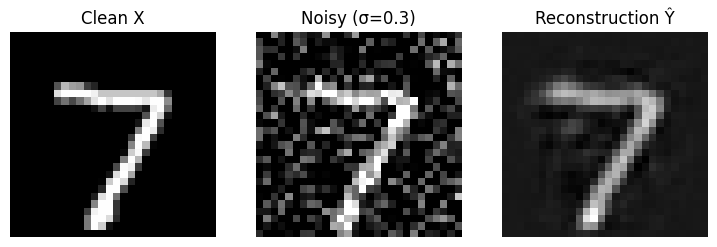

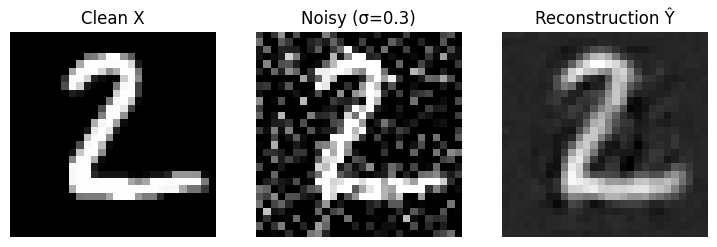

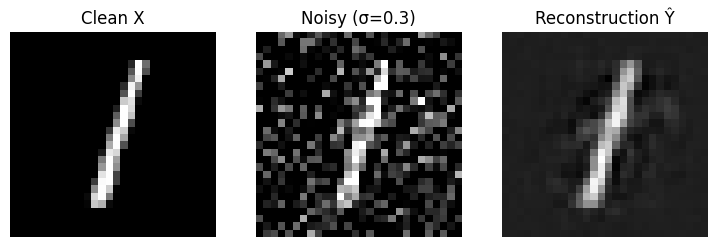

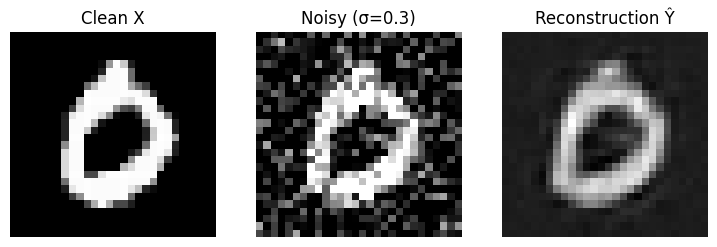

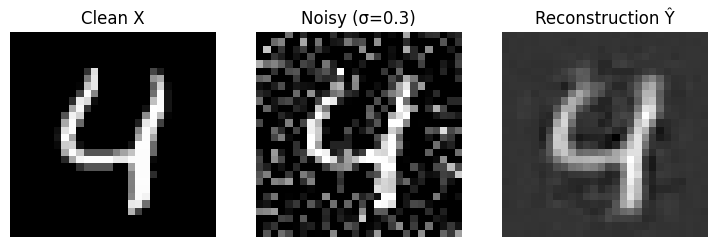

In [12]:
model.eval()
n_show = 5
sigma_display = TRAIN_SIGMA

with torch.no_grad():
    x, _ = next(iter(test_loader))
    x = x.to(device)
    x_noisy = add_noise(x, sigma_display)
    x_hat, _ = model(x_noisy)

def show_triplet(clean, noisy, recon, idx):
    fig = plt.figure(figsize=(9,3))
    plt.subplot(1,3,1); plt.imshow(clean[idx,0].cpu(), cmap="gray"); plt.axis("off"); plt.title("Clean X")
    plt.subplot(1,3,2); plt.imshow(noisy[idx,0].cpu(), cmap="gray"); plt.axis("off"); plt.title(f"Noisy (σ={sigma_display})")
    plt.subplot(1,3,3); plt.imshow(recon[idx,0].cpu(), cmap="gray"); plt.axis("off"); plt.title("Reconstruction Ŷ")
    plt.show()

for i in range(n_show):
    show_triplet(x, x_noisy, x_hat, i)


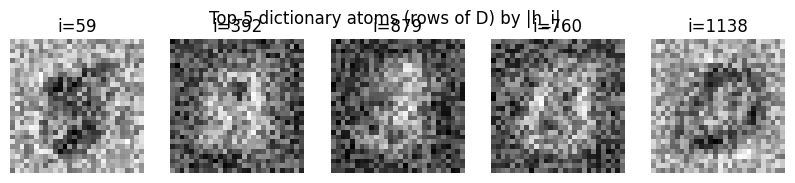

In [13]:
model.eval()
with torch.no_grad():
    x_sample, _ = test_ds[random.randrange(len(test_ds))]
    x_sample = x_sample.unsqueeze(0).to(device)
    x_noisy_s = add_noise(x_sample, sigma_display)
    x_hat_s, h_s = model(x_noisy_s)            # h_s: [1, H_DIM]
    h_abs = h_s[0].abs().detach().cpu().numpy()
    topk_idx = np.argsort(-h_abs)[:5]          # top-5 |h_i|

D = model.dec.D.detach().cpu()                 # [H_DIM, INPUT_DIM]

fig = plt.figure(figsize=(10,2))
for j, idx in enumerate(topk_idx, 1):
    atom = D[idx].view(28,28).numpy()
    plt.subplot(1,5,j); plt.imshow(atom, cmap="gray"); plt.axis("off"); plt.title(f"i={int(idx)}")
plt.suptitle("Top-5 dictionary atoms (rows of D) by |h_i|"); plt.show()


σ=0.00  MSE=0.011618
σ=0.10  MSE=0.008486
σ=0.20  MSE=0.007650
σ=0.30  MSE=0.009242
σ=0.50  MSE=0.018580
σ=0.80  MSE=0.036046
σ=1.00  MSE=0.045155


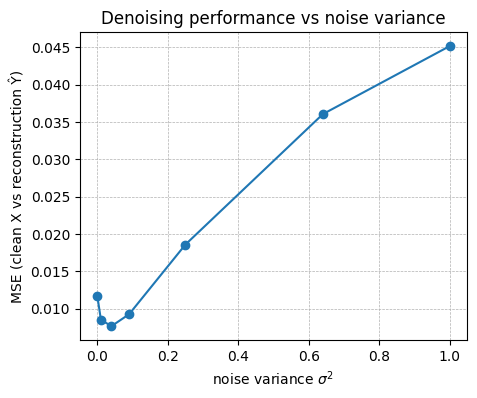

In [14]:
def eval_mse_at_sigma(sigma):
    model.eval()
    total, count = 0.0, 0
    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)
            x_noisy = add_noise(x, sigma)
            x_hat, _ = model(x_noisy)
            total += F.mse_loss(x_hat, x, reduction="sum").item()
            count += x.numel()
    return total / count  # average per-pixel MSE

sigmas = [0.0, 0.1, 0.2, 0.3, 0.5, 0.8, 1.0]
mse_vals = [eval_mse_at_sigma(s) for s in sigmas]

for s, v in zip(sigmas, mse_vals):
    print(f"σ={s:.2f}  MSE={v:.6f}")

plt.figure(figsize=(5,4))
plt.plot([s*s for s in sigmas], mse_vals, marker="o")
plt.xlabel(r"noise variance $\sigma^2$")
plt.ylabel("MSE (clean X vs reconstruction Ŷ)")
plt.title("Denoising performance vs noise variance")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()
